# <center>ASTR4004/8004 - Inference - Part 2</center> 

## Bayes' theorem:
$$
P(\theta|D)=P(D|\theta)\frac{P(\theta)}{P(D)}
$$

* $P(D|\theta)$: the likelihood function, representing the probability of observing the data ($D$) given a specific set of modeling parameters ($\theta$)
* $P(\theta)$: the prior probability distribution over the modeling parameters ($\theta$). This represents our initial beliefs of possible values of $\theta$
* $P(D)\equiv \sum \limits_{\theta} P(D,\theta)=\sum \limits_{\theta} P(D|\theta)P(\theta) = \int {\rm d}\theta P(\theta) P(D|\theta)$: the marginal likelihood or Bayesian evidence, representing the overall probability of observing the data (D)
* $P(\theta|D)$: the posterior probability distribution over the modeling parameters ($\theta$) given the data.

This notebook fits the distribution of a dataset within a Bayesian framework. The model  considered here is a Normal distribution with the mean and variance treated as free parameters.

## Useful packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

## Data (D) and the task
We will be given a dataset and the task is to find a distribution to fit it

Text(0, 0.5, 'PDF')

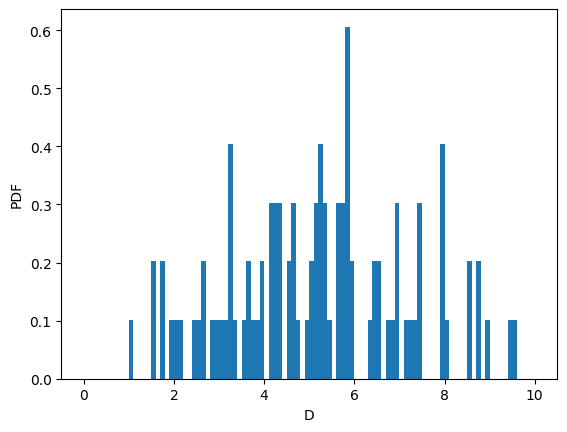

In [2]:
# Set seed for reproducibility
np.random.seed(0)

# Generate dataset (100 data points) following a normal distribution
mean_real, std_real = 5, 2
n_data = 100
data = np.random.normal(loc=mean_real, scale=std_real, size=n_data)
plt.hist(data, bins=100, range=(0,10), density=True)
plt.xlabel('D')
plt.ylabel('PDF')

## Propose your model
* It "seems" that our dataset $D$ follows a normal distribution. So we decide to fit it using a normal distribution.
* Therefore, out parameter $\theta$ corresponds to the mean (`mean`) and standard deviation (`std`)

## Let's write a generic function to sample from a 2D parameter space (x,y) based on any given `pdf(x,y)`

Inverse CDF sampling is primarily designed for generating samples from one-dimensional distributions. When it comes to high-dimensional distributions, it becomes more complex and often impractical to compute and invert the CDF, which is a multidimensional function.

a commonly used algorithm for high dimension is the rejection sampling: a uniform samples from $u(x)$ can be modified to follow $p(x)$ by rejecting samples according to the ratio of $p(x)/u(x)$. That's to say that, where $u(x)$ and $p(x)$ are similar we keep the most of values generate from $u(x)$, and when $u(x) >> p(x)$ we throw the majority away.

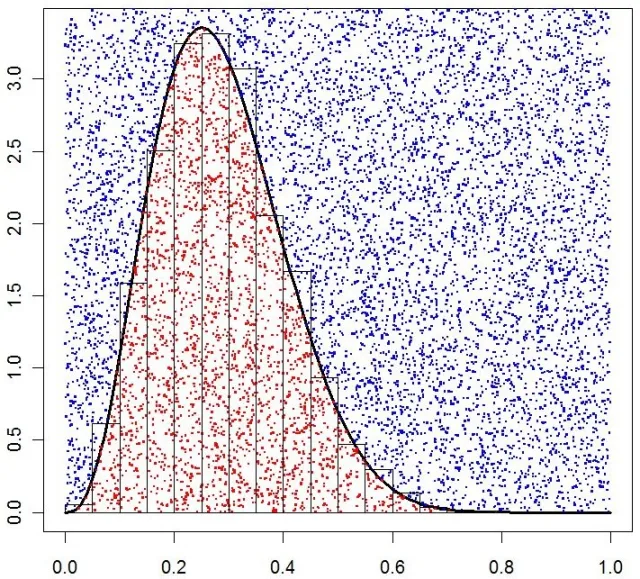

In [4]:
def sample_parameters(pdf, x_min, x_max, y_min, y_max, num_samples):
    '''
    Samping using rejection

    Parameters:
    - pdf: a function that takes (mean, std) as input and outputs its probability
    - x_min, x_max, y_min, y_max: range to sample 
    - num_samples: the number of sample to generate

    Return:
    - x_samples, y_samples: the sample that following the given pdf 
    - efficiecy: the sampling efficiency
    '''
    
    x_samples = np.zeros(num_samples)
    y_samples = np.zeros(num_samples)

    i = 0
    counter = 0
    while i<num_samples:
        counter += 1
        x = np.random.uniform(x_min, x_max, size=1)
        y = np.random.uniform(y_min, y_max, size=1)

        u = np.random.rand() / (y_max-y_min) / (x_max-x_min)

        if u < pdf(x,y):
            x_samples[i] = x
            y_samples[i] = y
            i+=1
    return x_samples, y_samples, float(num_samples) / counter

### uniform between $x\in[-1,1]$ and $y\in[-1,1]$

(-2.0, 2.0)

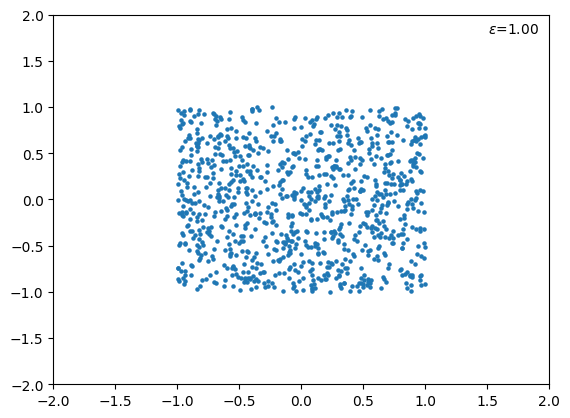

In [11]:
def pdf(x,y):
    if x<-1 or x>1 or y<-1 or y>1: 
        return 0
    else:
        return 0.25
    
x_samples, y_samples, efficiency = sample_parameters(pdf, -1,1, -1, 1, 1000)
plt.scatter(x_samples, y_samples, s=5)
plt.text(0.98, 0.98, r'$\epsilon$=%.2f'%efficiency, 
         va='top', ha='right', transform=plt.gca().transAxes)
plt.xlim(-2,2)
plt.ylim(-2,2)

### uniform within the circle of $x^2+y^2<1$

(-1.0, 1.0)

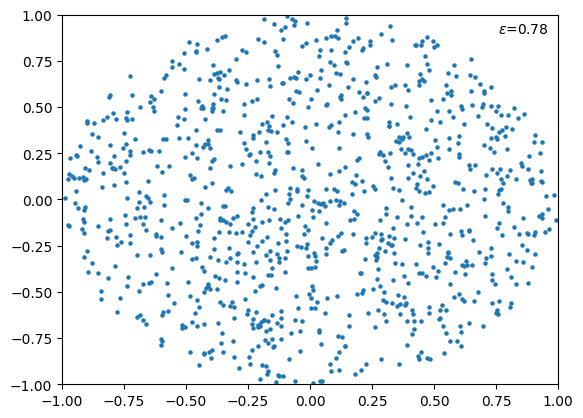

In [7]:
def pdf(x,y):
    if x**2+y**2>1: return 0
    else: return 1/np.pi
    
x_samples, y_samples, efficiency = sample_parameters(pdf, -1, 1, -1, 1, 1000)
plt.scatter(x_samples, y_samples, s=5)
plt.text(0.98, 0.98, r'$\epsilon$=%.2f'%efficiency, 
         va='top', ha='right', transform=plt.gca().transAxes)
plt.xlim(-1,1)
plt.ylim(-1,1)

## 2D Normal distribution

(-5.0, 5.0)

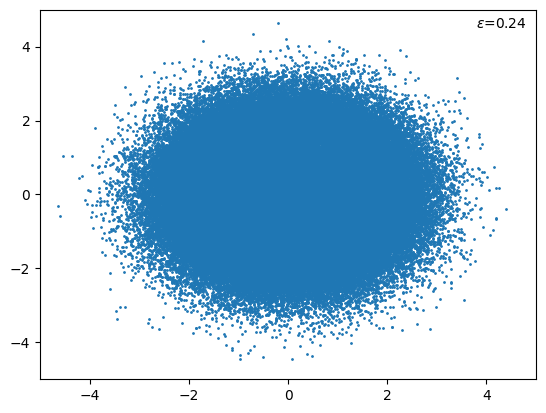

In [10]:
def norm_pdf(x, mean, std):
    return np.exp(-((x - mean) / std)**2 / 2) / (std * np.sqrt(2 * np.pi))

def pdf(x,y):
    return norm_pdf(x,0,1) * norm_pdf(y,0,1)
    
x_samples, y_samples, efficiency = sample_parameters(pdf, -5, 5, -5, 5, 100000)
plt.scatter(x_samples, y_samples, s=1)
plt.text(0.98, 0.98, r'$\epsilon$=%.2f'%efficiency, 
         va='top', ha='right', transform=plt.gca().transAxes)
plt.xlim(-5,5)
plt.ylim(-5,5)

<font color='red'>The rejection sampling gets very inefficient with peaky PDFs and/or higher dimensions, because the rejected fraction scales with the **volume** ratio of the sample and target PDFs.</font>

## Define the prior of your model parametersm

In [12]:
mean_min, mean_max = 4, 6
std_min, std_max   = 1, 3

# an uninformative prior
def initial_prior(mean, std):
    return 1.0 / (mean_max - mean_min) / (std_max - std_min)

## Calculate the likelihood 
We have picked the Normal distribution as our model, then for a given set of model parameters, $\theta$ or $\mu$ (`mean`) and $\sigma$ (`std`), the likelihood function of data $D$ or `x` is simply 
$$
P(D|\theta) \equiv P(x|\mu,\sigma) = \frac{1}{\sqrt{2\pi}\sigma}\exp{\left[-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2\right]}
$$

In [13]:
def likelihood(x, mean, std):
    return np.exp(-((x - mean) / std)**2 / 2) / (std * np.sqrt(2 * np.pi))

## Bayesian inference

/jobfs/127107456.gadi-pbs/ipykernel_548602/1363557066.py:59: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f_interp = interp2d(mean_samples, std_samples, posterior_samples)
/home/563/yq5547/virtualenvs/py21cmfast/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=30,38 m=1000 fp=0.000000 s=0.000000
  warnings.w

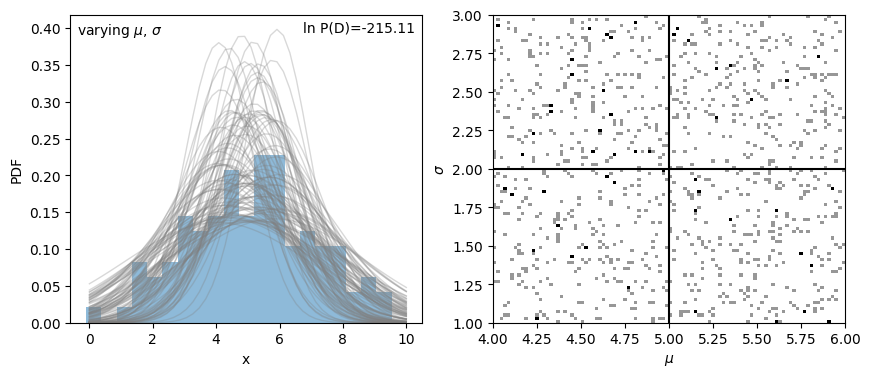

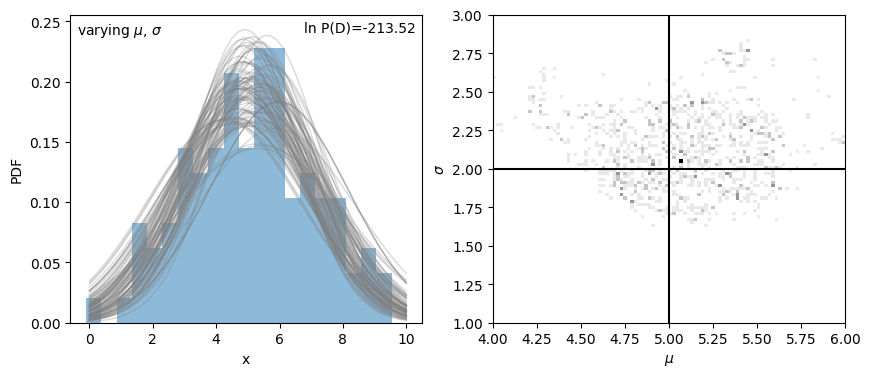

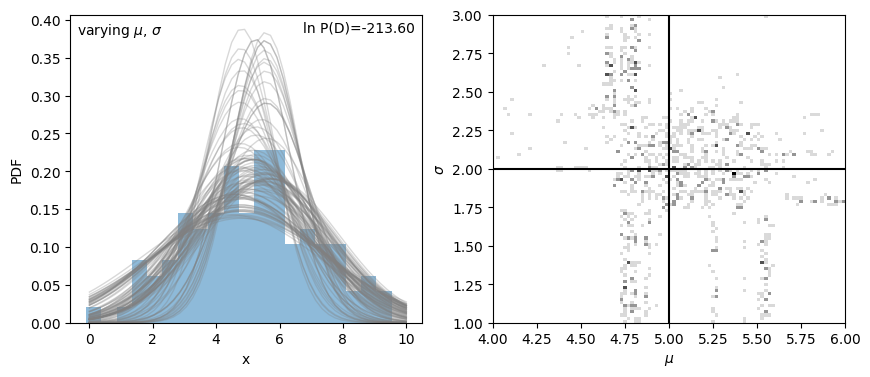

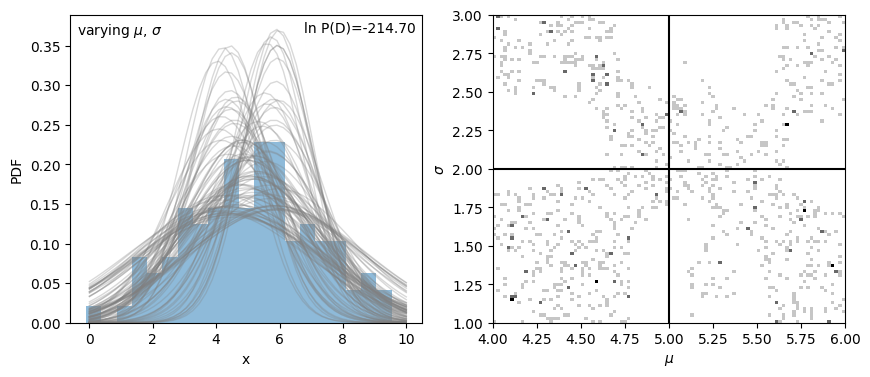

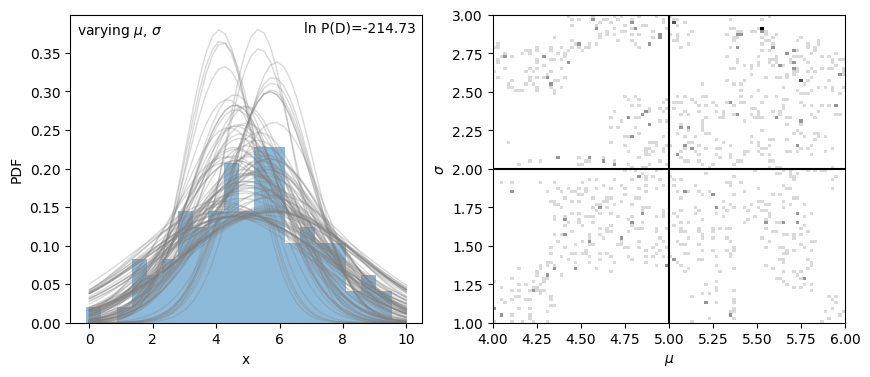

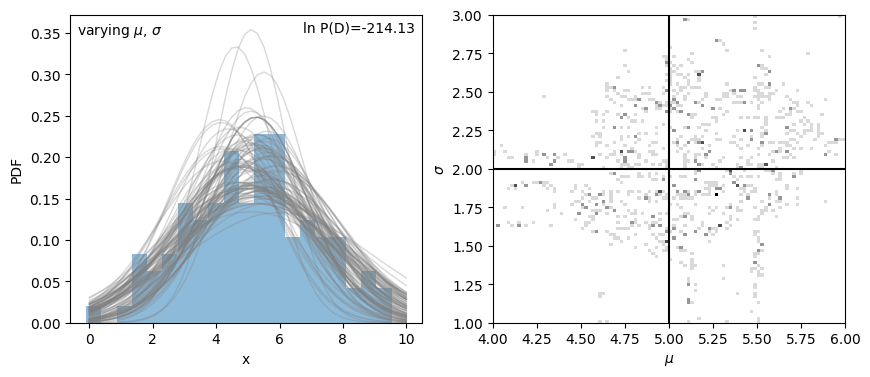

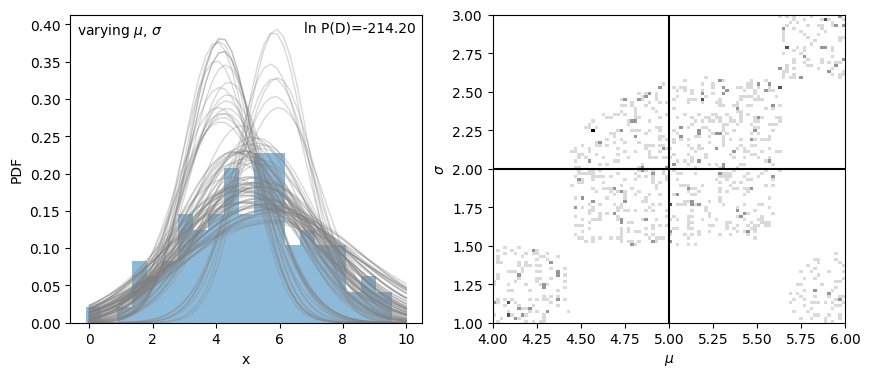

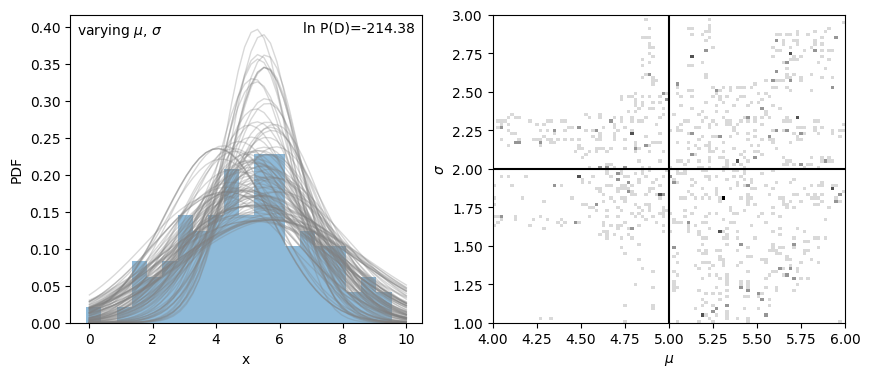

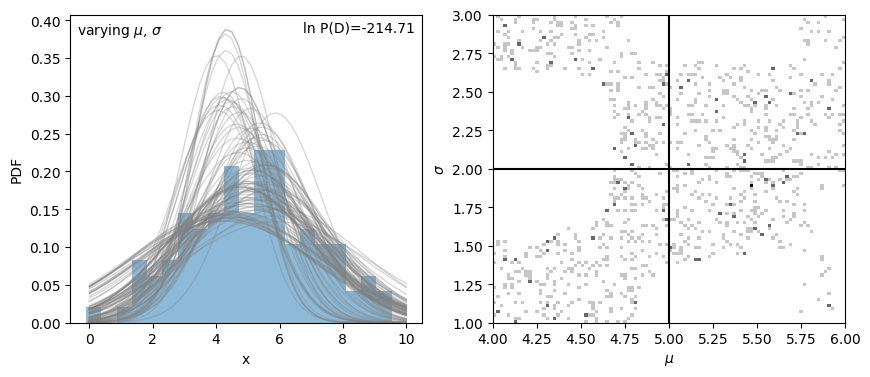

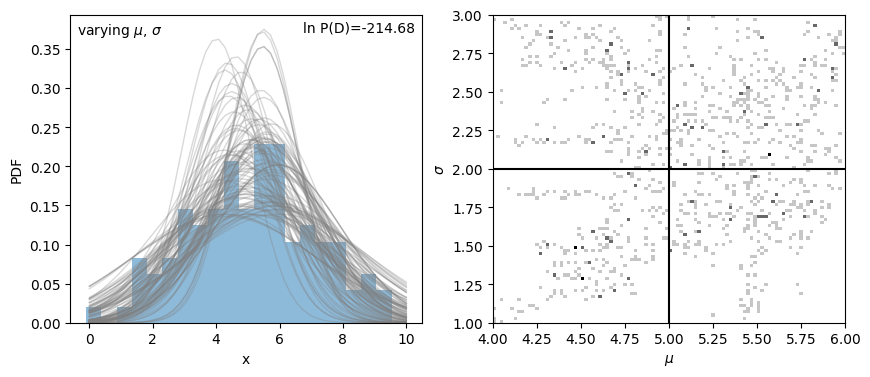

In [14]:
num_samples = 1000 # Number of samples in the parameter space
num_steps = 10 # Number of inteferencing steps
xs = np.linspace(0,10) # for plotting modelled distribution

# sample parameters based on the initial prior
prior = initial_prior
mean_samples, std_samples, efficiency = sample_parameters(initial_prior, mean_min, mean_max, std_min, std_max, num_samples)

prior_samples        = np.zeros(num_samples)
likelihood_samples   = np.zeros(num_samples)
posterior_samples    = np.zeros(num_samples)

# Inference loop
for istep in range(num_steps):
    
    # calculate prior, likelihood, marginal likelihood and posterior 
    for i in range(num_samples):
        prior_samples[i] = prior(mean_samples[i], std_samples[i])
        likelihood_samples[i] = np.prod(norm_pdf(data, mean_samples[i], std_samples[i]))

        # Baye's rule
        posterior_samples[i] = likelihood_samples[i] * prior_samples[i]

    marginal_likelihoods = np.sum(likelihood_samples) / num_samples
    posterior_samples   /= marginal_likelihoods
    
    # Plot the data distrbution
    fig, axs = plt.subplots(1,2, figsize=(10,4))
    axs[0].hist(data, bins=20, alpha=0.5, density=True)
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('PDF')

    # Randomly pick a few samples and plot our modelled distribution
    for idx in np.random.randint(0, num_samples, size=100):
        axs[0].plot(xs, norm_pdf(xs, mean_samples[idx], std_samples[idx]) , lw=1, alpha=0.3, c='grey')

    # Print the marginal likelihood
    axs[0].text(0.98, 0.98, r'ln P(D)=%.2f'%np.log(marginal_likelihoods), 
               ha='right', va='top', transform=axs[0].transAxes)

    axs[0].text(0.02, 0.98, r'varying $\mu$, $\sigma$',
               ha='left', va='top', transform=axs[0].transAxes)

    # Plot the 2D distribution of model parameters
    axs[1].hist2d(mean_samples, std_samples, 
                  range=((mean_min, mean_max), (std_min, std_max)), 
                  bins=100, density=True, cmap='Greys')

    # Show the truth
    axs[1].axvline(mean_real, color='k')
    axs[1].axhline(std_real, color='k')

    axs[1].set_xlim(mean_min, mean_max)
    axs[1].set_ylim(std_min, std_max)

    axs[1].set_xlabel(r'$\mu$')
    axs[1].set_ylabel(r'$\sigma$')

    f_interp = interp2d(mean_samples, std_samples, posterior_samples)
    def prior(mean, std):
        return f_interp(mean, std)
    
    mean_samples, std_samples, efficiency = sample_parameters(prior, mean_min, mean_max, std_min, std_max, num_samples)

<font color='red'>It also becomes numerically challenging to generate sample PDFs that appropriately encapsulate the full parameter space of the target PDF. We see interpolation in this case performs poorly.</font>

### focus on the subsample 

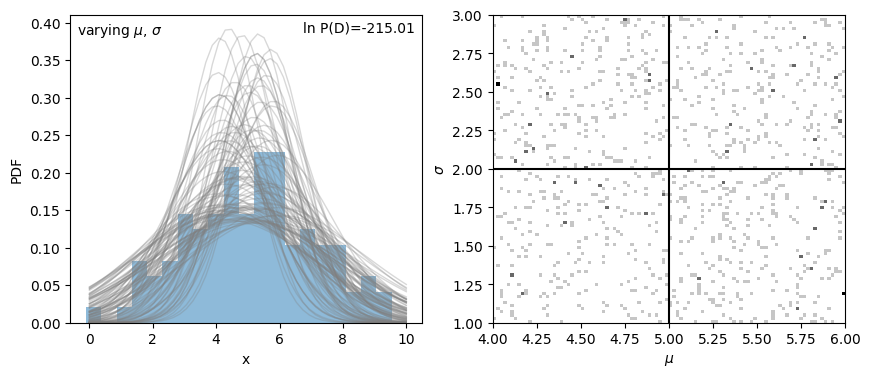

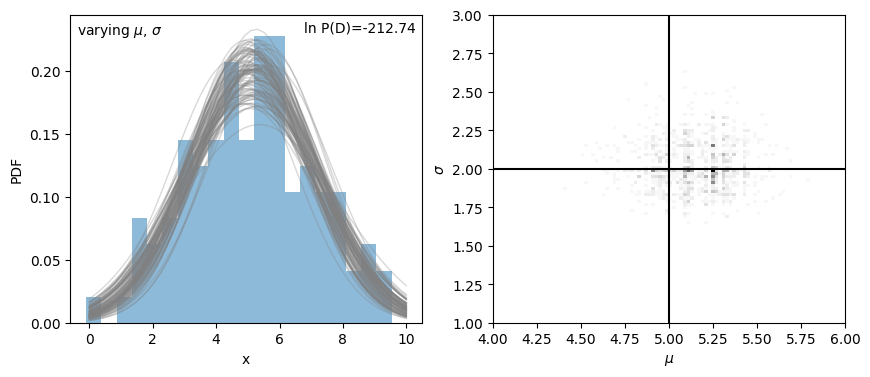

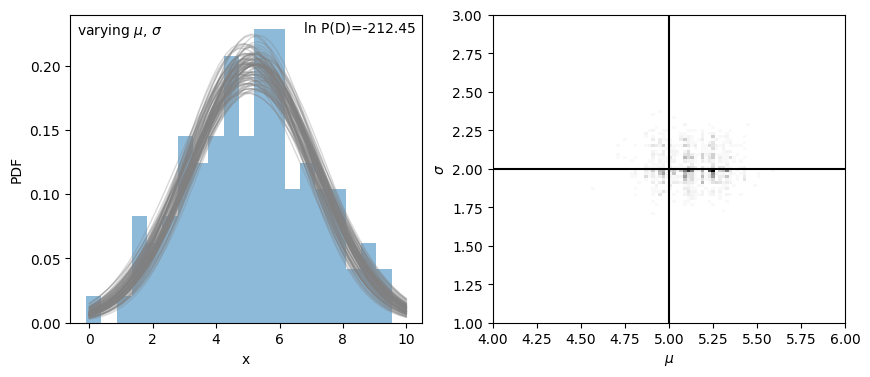

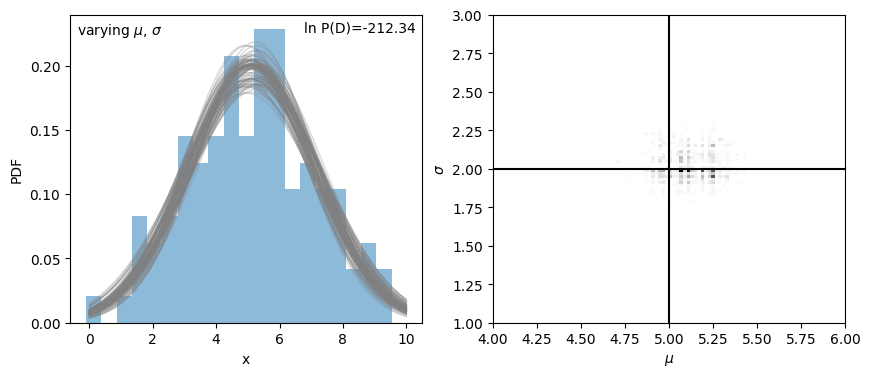

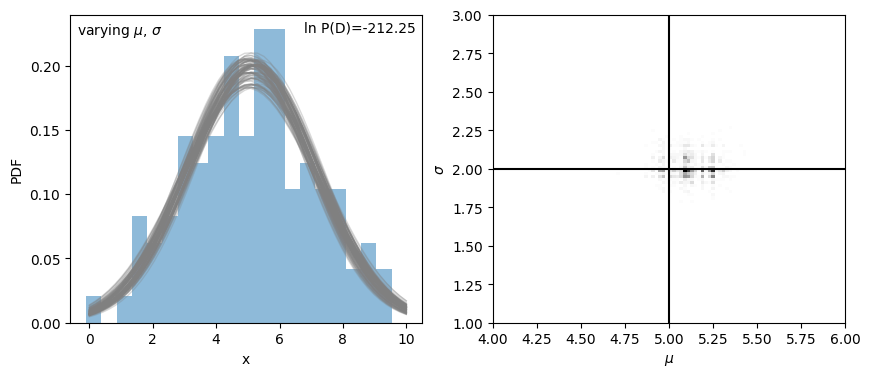

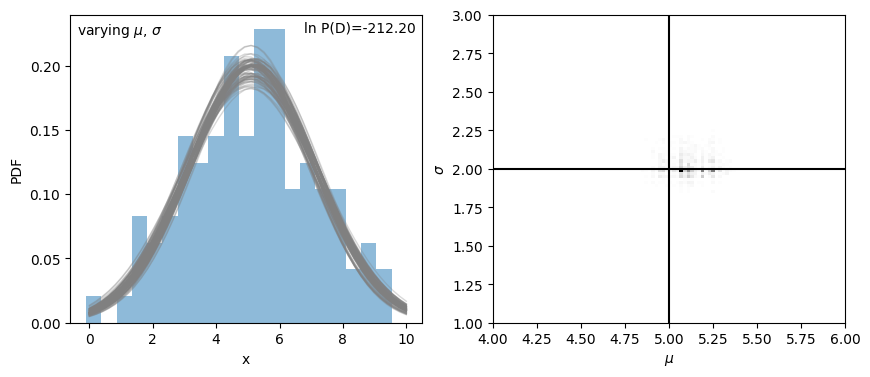

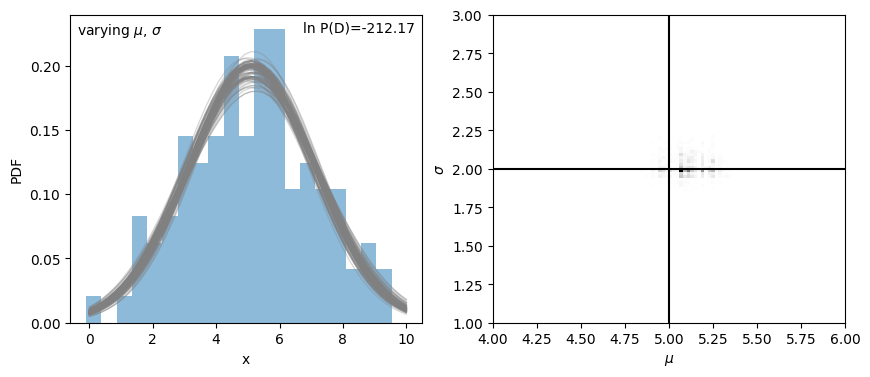

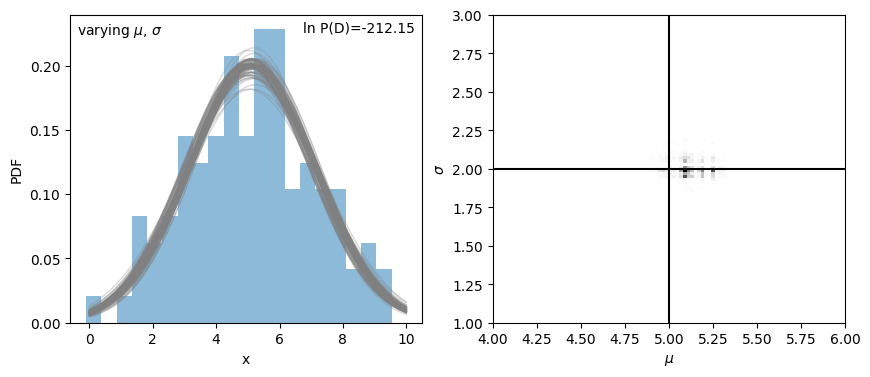

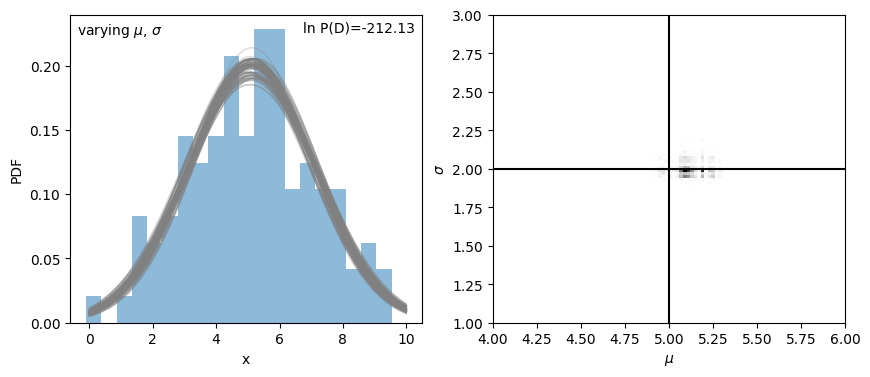

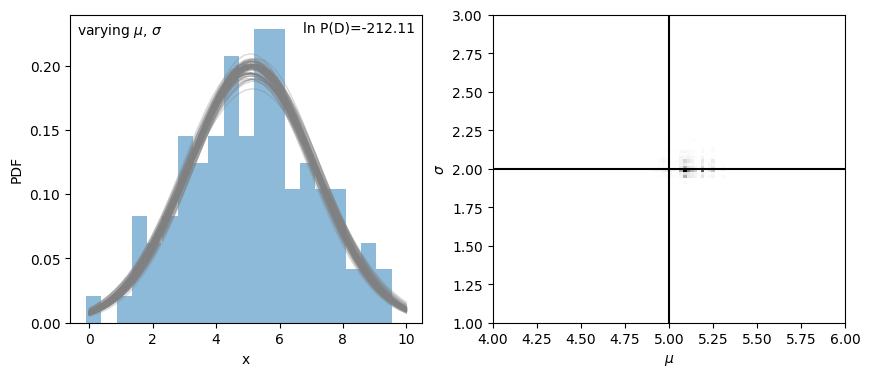

In [15]:
num_samples = 1000 # Number of samples in the parameter space
num_steps = 10 # Number of inteferencing steps
xs = np.linspace(0,10) # for plotting modelled distribution

# sample parameters based on the initial prior
prior = initial_prior
mean_samples, std_samples, efficiency = sample_parameters(initial_prior, mean_min, mean_max, std_min, std_max, num_samples)

prior_samples        = np.zeros(num_samples)
likelihood_samples   = np.zeros(num_samples)
posterior_samples    = np.zeros(num_samples)

# Inference loop
for istep in range(num_steps):
    
    # calculate prior, likelihood, marginal likelihood and posterior 
    for i in range(num_samples):
        prior_samples[i] = prior(mean_samples[i], std_samples[i])
        likelihood_samples[i] = np.prod(norm_pdf(data, mean_samples[i], std_samples[i]))

        # Baye's rule
        posterior_samples[i] = likelihood_samples[i] * prior_samples[i]

    marginal_likelihoods = np.sum(likelihood_samples) / num_samples
    posterior_samples   /= marginal_likelihoods
    
    # Plot the data distrbution
    fig, axs = plt.subplots(1,2, figsize=(10,4))
    axs[0].hist(data, bins=20, alpha=0.5, density=True)
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('PDF')

    # Randomly pick a few samples and plot our modelled distribution
    for idx in np.random.randint(0, num_samples, size=100):
        axs[0].plot(xs, norm_pdf(xs, mean_samples[idx], std_samples[idx]) , lw=1, alpha=0.3, c='grey')

    # Print the marginal likelihood
    axs[0].text(0.98, 0.98, r'ln P(D)=%.2f'%np.log(marginal_likelihoods), 
               ha='right', va='top', transform=axs[0].transAxes)

    axs[0].text(0.02, 0.98, r'varying $\mu$, $\sigma$',
               ha='left', va='top', transform=axs[0].transAxes)

    # Plot the 2D distribution of model parameters
    axs[1].hist2d(mean_samples, std_samples, 
                  range=((mean_min, mean_max), (std_min, std_max)), 
                  bins=100, density=True, cmap='Greys')

    # Show the truth
    axs[1].axvline(mean_real, color='k')
    axs[1].axhline(std_real, color='k')

    axs[1].set_xlim(mean_min, mean_max)
    axs[1].set_ylim(std_min, std_max)

    axs[1].set_xlabel(r'$\mu$')
    axs[1].set_ylabel(r'$\sigma$')

    # now consider the posterior as prior for the next inferecing step
    weights = posterior_samples / np.sum(posterior_samples)
    mean_samples = np.random.choice(mean_samples, size=num_samples, replace=True, p=weights) +  np.random.uniform(-0.01,0.01)
    std_samples = np.random.choice(std_samples, size=num_samples, replace=True, p=weights)   +  np.random.uniform(-0.01,0.01)

<font color='red'>Focusing on subsamples can easily lead to biased results as the intial sample might have missed the global maximum of the PDF </font>

### Metropolis–Hastings algorithm

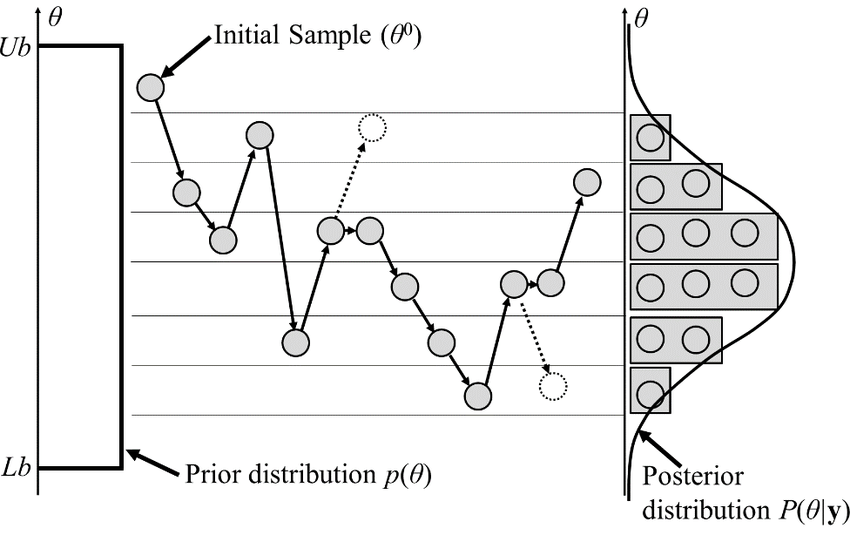

A simple algorithm might look something like:
- Generate a set of samples $x$
- Draw a new sample $x^{\prime}$ according to some _local_ proposal distribution
- Accept proposal if $p(x^{\prime})/p(x) \ge 1$, accept with some non-zero probability if $p(x^{\prime})/p(x) < 1$.
- repeat.

In [ ]:
def posterior(x, mean, std):
    return np.prod(likelihood(x, mean, std)) * initial_prior(mean, std)
    
def metropolis_hastings(pdf, x_current, y_current, num_samples, step_size):
    '''
    Samping using the Metropolis–Hastings algorithm

    Parameters:
    - pdf: the target pdf that takes (mean, std) as input and outputs its probability
    - x_current, y_current: the current sample
    - num_samples: the size of the sample
    - step_size: the size of step to take when proposing new points

    Return:
    - x_proposed, y_proposed: the new sample
    - efficiecy: the sampling efficiency
    '''

    ...

In [ ]:
num_samples = 1000 # Number of samples in the parameter space
num_steps = 10 # Number of inteferencing steps
xs = np.linspace(0,10) # for plotting modelled distribution

# sample parameters based on the initial prior
prior = initial_prior
mean_samples, std_samples, efficiency = sample_parameters(initial_prior, mean_min, mean_max, std_min, std_max, num_samples)

likelihood_samples   = np.zeros(num_samples)

# Inference loop
for istep in range(num_steps):
    
    # calculate prior, likelihood, marginal likelihood and posterior 
    for i in range(num_samples):
        likelihood_samples[i] = np.prod(norm_pdf(data, mean_samples[i], std_samples[i]))
    marginal_likelihoods = np.sum(likelihood_samples) / num_samples
    
    # Plot the data distrbution
    fig, axs = plt.subplots(1,2, figsize=(10,4))
    axs[0].hist(data, bins=20, alpha=0.5, density=True)
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('PDF')

    # Randomly pick a few samples and plot our modelled distribution
    for idx in np.random.randint(0, num_samples, size=100):
        axs[0].plot(xs, norm_pdf(xs, mean_samples[idx], std_samples[idx]) , lw=1, alpha=0.3, c='grey')

    # Print the marginal likelihood
    axs[0].text(0.98, 0.98, r'ln P(D)=%.2f'%np.log(marginal_likelihoods), 
               ha='right', va='top', transform=axs[0].transAxes)

    axs[0].text(0.02, 0.98, r'varying $\mu$, $\sigma$',
               ha='left', va='top', transform=axs[0].transAxes)

    # Plot the 2D distribution of model parameters
    axs[1].hist2d(mean_samples, std_samples, 
                  range=((mean_min, mean_max), (std_min, std_max)), 
                  bins=100, density=True, cmap='Greys')

    # Show the truth
    axs[1].axvline(mean_real, color='k')
    axs[1].axhline(std_real, color='k')

    axs[1].set_xlim(mean_min, mean_max)
    axs[1].set_ylim(std_min, std_max)

    axs[1].set_xlabel(r'$\mu$')
    axs[1].set_ylabel(r'$\sigma$')

    mean_samples, std_samples, efficiency = metropolis_hastings(posterior, mean_samples, std_samples, num_samples, step_size=0.2)

<font color='red'> Also note the *caveat* that the marginal likelihood here is weighted by the updated prior in each step, rather than using the intial prior. Therefore, we are biased towards high probability regions. In addition, points in a sample might only have a uniform volume when initialized to be uniform and are very likely not the case at later times! </font>

## Monte Carlo Markov Chain
* Monte Carlo: random sampling
* Markov: each new sample depends and only depends on the previous one:$$ P(S_{n+1}|S_{n}, S_{n-1}, S_{n-2},...)=P(S_{n+1}|S_{n}),$$ meaning that given the current state $S_{n}$, the next state $S_{n+1}$ is determined without any knowledge of how the system has arrived at $S_{n}$.
* Chain: a sequence of samples.

In [ ]:
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf']
num_samples = 8 # Number of samples in the parameter space
num_steps = 1000 # Number of inteferencing steps

# sample parameters based on the initial prior
prior = initial_prior
mean_samples, std_samples, efficiency = sample_parameters(initial_prior, mean_min, mean_max, std_min, std_max, num_samples)
#mean_samples, std_samples, efficiency = sample_parameters(initial_prior, 0, 0.1, 10, 10.1, num_samples)

likelihood_samples   = np.zeros([num_samples, num_steps])
chains               = np.zeros([num_samples, num_steps, 2]) # store data to show the chain evolution

# Inference loop
for istep in range(num_steps):
    
    # calculate prior, likelihood, marginal likelihood and posterior 
    for i in range(num_samples):
        likelihood_samples[i,istep] = np.prod(norm_pdf(data, mean_samples[i], std_samples[i]))

    chains[:,istep] = np.vstack([mean_samples, std_samples]).T
    
    mean_samples, std_samples, efficiency = metropolis_hastings(posterior, mean_samples, std_samples, num_samples, step_size=0.2)
    
fig = plt.figure(figsize=(12, 6))
    
ax1 = fig.add_subplot(141)  # Note: add_subplot takes the position from left to right and top to bottom
ax1.set_position([0.05, 0.05, 0.47, 0.94])  # Set the position and size of the subplot
    
ax21 = fig.add_subplot(142)  # Note: add_subplot takes the position from left to right and top to bottom
ax21.set_position([0.59, 0.69, 0.4, 0.3])  # Set the position and size of the subplot
    
ax22 = fig.add_subplot(143)  # Note: add_subplot takes the position from left to right and top to bottom
ax22.set_position([0.59, 0.37, 0.4, 0.3])  # Set the position and size of the subplot

ax23 = fig.add_subplot(144)  # Note: add_subplot takes the position from left to right and top to bottom
ax23.set_position([0.59, 0.05, 0.4, 0.3])  # Set the position and size of the subplot

for iwalker in range(num_samples):
    # Plot one chain in 2D parameter space
    if iwalker==0:
        ax1.plot(chains[iwalker,:,0], chains[iwalker,:,1], marker='o', lw=1,markersize=1,alpha=0.3, zorder=1, color=colors[iwalker])

    # Plot the Markov Chain
    ax21.plot(chains[iwalker,:,0], lw=1, alpha=0.3, color=colors[iwalker])
    ax22.plot(chains[iwalker,:,1], lw=1, alpha=0.3, color=colors[iwalker])
    ax23.plot(np.log(likelihood_samples[iwalker]), lw=1, alpha=0.3, color=colors[iwalker])

ax1.scatter(mean_real, std_real, marker='*', c='k', s=500, zorder=2)
ax1.set_xlabel(r'$\mu$')
ax1.set_ylabel(r'$\sigma$')
    
ax1.text(0.02, 0.98, r'varying $\mu$, $\sigma$',
         ha='left', va='top', transform=ax1.transAxes)

# Show the truth
ax21.axhline(mean_real, color='k')
ax22.axhline(std_real, color='k')

ax21.set_xlim(0, num_steps)
ax22.set_xlim(0, num_steps)
ax23.set_xlim(0, num_steps)

ax21.set_xticks([])
ax22.set_xticks([])
ax23.set_xlabel('step')

ax21.set_ylabel(r'$\mu$')
ax22.set_ylabel(r'$\sigma$')
ax23.set_ylabel('ln (likelihood)')